<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/park_area_within500ft%26camera_location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd

try:
  import geopandas as gp
except:
  !pip install geopandas

import pyproj
from matplotlib import pyplot as plt
from shapely.geometry import Point

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# -- read in the camera data
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

In [ ]:
# -- define helper function for integrating within a circle
def integrate_geodata(geo, vals, lat, lon, rad):
  
  # -- convert lat/lon to NY State Plane
  ll_nyspd = pyproj.Proj("epsg:2263", preserve_units=True)(lon, lat)
  
  # -- define a circle
  circ = Point(ll_nyspd[0], ll_nyspd[1]).buffer(rad)
  
  # -- calculate the intersection of the circle with the geometry
  inter = geo.buffer(0).intersection(circ)
  
  # -- determine the overlap fraction
  frac = inter.area / geo.area
  return (frac * vals).sum() 

In [ ]:
# -- convert a geodataframe to NYSP coords
def convert_to_nyc(input_data):
  input_data.geometry = input_data.geometry.to_crs(epsg=2263)

In [ ]:
# for each camera:
park_fname = os.path.join("drive", "My Drive", "lwir", "data", "parks", 
                          "properties", 
                          "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp")
park = gp.read_file(park_fname)
park_data = park[park["borough"] == "M"].copy()

In [ ]:
# -- convert Manhattan parks geometries to NYSP
convert_to_nyc(park_data)

In [ ]:
# -- calcualte park area within 500 ft
cam_len = len(camera)
rad = 500.
park_area = []

for ii in range(cam_len):

  if ii % 15 == 0:
    print("working on {0} of {1}".format(ii, cam_len))

  park_area.append(integrate_geodata(park_data.geometry, park_data.area, 
                                     camera.lat[ii], camera.lon[ii], rad))


working on 0 of 157
working on 15 of 157
working on 30 of 157
working on 45 of 157
working on 60 of 157
working on 75 of 157
working on 90 of 157
working on 105 of 157
working on 120 of 157
working on 135 of 157
working on 150 of 157


In [ ]:
# -- create DataFrame holding park area
park_area_df = pd.DataFrame(park_area, columns=["park_area_500ft"])

In [ ]:
# -- write to csv
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "parkarea.csv")
park_area_df.to_csv(oname, index=False)

<Figure size 432x288 with 0 Axes>

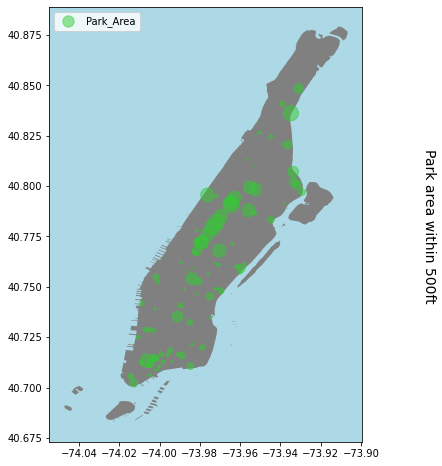

In [ ]:
# -- plot it
#    (Borough geojson from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
bpath = os.path.join("drive", "My Drive", "lwir", "data", "boro_boundaries")
bname = "Borough Boundaries.geojson"
boros = gp.read_file(os.path.join(bpath, bname))
boros = boros[boros.boro_name == "Manhattan"]

# -- set the parks geometries file name
dpath = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties")
fname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

fig = plt.figure()

# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)

ax.scatter(camera.lon, camera.lat, s=park_area_df/2000., alpha=0.5, color="limegreen", label='Park_Area')
ax.legend(loc='upper left')
#plt.title("Enclosed Park Area in Manhattan")

fig.text(0.9, 0.5, "Park area within 500ft", ha="center", 
         va="center", rotation=-90, fontsize=14)
outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure7", "Enclosed Park Area in Manhattan.png")
fig.savefig(outfile)


In [ ]:
fig = plt.figure()

# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="grey", ax=ax, legend=True)
parks_m.plot(color="orange", ax=ax, legend=True)

ax.scatter(camera.lon, camera.lat, color="green", label='Camera Location')
ax.legend(loc='upper left')
#plt.title("Enclosed Park Area in Manhattan")

outfile = os.path.join("drive", "My Drive", "lwir", "output", "Camera Location in Manhattan.png")
fig.savefig(outfile)

In [ ]:
# -- set indices of cameras that don't have 3-peak behavior
bind = [0, 5, 8, 11, 13, 19, 36, 45, 48, 51, 52, 60, 62, 63, 66, 67, 68, 69, 
        74, 79, 80, 81, 89, 93, 94, 98, 99, 103, 104, 106, 110, 113, 114, 115, 
        121, 125, 137, 138, 139, 146, 151]
camdf = camera[~camera.index.isin(bind)].copy()
camdrop = camera[camera.index.isin(bind)].copy()

In [ ]:
fig = plt.figure()

# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="grey", ax=ax, legend=True)
parks_m.plot(color="orange", ax=ax, legend=True)

ax.scatter(camdf.lon, camdf.lat, color="green", label='Camera Location')
ax.scatter(camdrop.lon, camdrop.lat, marker="x", color="red", label='Dropped Camera')
ax.legend(loc='upper left')
#plt.title("Enclosed Park Area in Manhattan")

outfile = os.path.join("drive", "My Drive", "lwir", "output", "dropped Camera Location in Manhattan.png")
fig.savefig(outfile)